#### Librerias

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

#### Nos fijamos si hay GPU para acelerar el entrenamiento

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Usamos el paquete torchvision para cargar el datsaet

In [13]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))                                           

In [14]:
batch_size = 200

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size)                                        

#### Creamos un metodo que nos entregue el nombre de la clase a partir de su id



In [15]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Visualizamos los datos

In [16]:
sample = next(iter(train_loader)) # iteramos en el dataloader para tomar una muestra
sample[0].size() # mostramos las dimensiones

torch.Size([200, 1, 28, 28])

In [17]:
len(train_set) # cantidad de muestras

60000

9 Ankle Boot


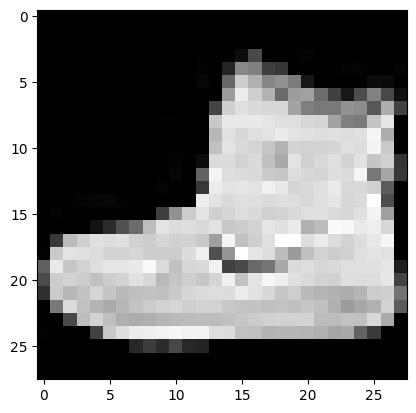

In [18]:
# Imprimimos una muestra
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label, output_label(label))

#### Imprimimos otros objetos

labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

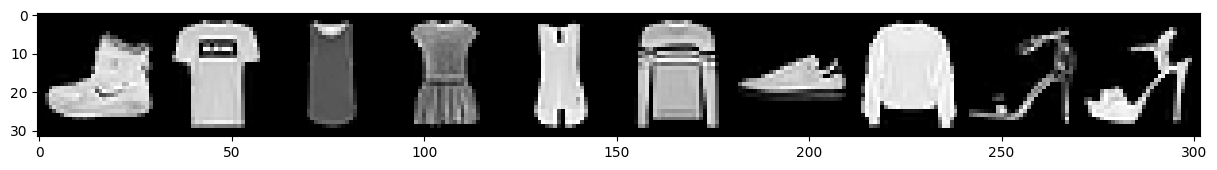

In [19]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

## Construimos la red neuronal

In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # normalizamos para acelerar el entrenamiento y reducir problema 
                                # de desvanecimiento del gradiente.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # capa de pooling para acelerar entrenamiento y evitar algunos problemas.
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25) # agregamos dropout para reducir overfitting
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # salida de la capa lineal, 10 clases
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


#### Creamos el modelo



In [21]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss() # función de perdida de entrenamiento

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # optimizador
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


#### Entrenamos y testeamos

In [22]:
def train(train_loader, optimizer, model, error):

    total = 0
    correct = 0

    for images, labels in train_loader:

        # Pasamos las imagenes a la GPU (si es que tenemos)
        images, labels = images.to(device), labels.to(device)
    
        # Paso Forward 
        outputs = model(images)
        loss = error(outputs, labels)
        
        # Inicializamos el gradiente en 0 para que no haya perdida del gradiente entre batches
        optimizer.zero_grad()
        
        # Paso backward
        loss.backward()
        
        # Optimizamos los parametros
        optimizer.step()

        # accuracy
        predictions = torch.max(outputs, 1)[1].to(device)
        correct += (predictions == labels).sum()
        total += len(labels)
    
    accuracy = correct * 100 / total


    return loss.data, accuracy

In [23]:
def test(test_loader, error):

    total = 0
    correct = 0

    with torch.no_grad():
        
        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
        
            outputs = model(images)
            loss = error(outputs, labels)
        
            predictions = torch.max(outputs, 1)[1].to(device)
            correct += (predictions == labels).sum()
        
            total += len(labels)
    
    accuracy = correct * 100 / total

    return loss.data, accuracy

In [ ]:
num_epochs = 5

# Listas para visualizar la perdida y el accuracy
accuracy_test_list = []
accuracy_train_list = []
loss_test_list = []
loss_train_list = []

for epoch in range(num_epochs):

    model.train()
    loss, accuracy = train(train_loader, optimizer, model, error)

    print("Train, loss: {},  Accuracy: {}%".format(loss, accuracy))

    accuracy_train_list.append(accuracy)
    loss_train_list.append(loss)

    model.eval()
    loss, accuracy = test(test_loader, error)

    print("Test, loss: {},  Accuracy: {}%".format(loss, accuracy))

    accuracy_test_list.append(accuracy)
    loss_test_list.append(loss)

c:\Users\franco\OneDrive\Escritorio\BUSCADOR DE OBJETOS\buscaor\lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train, loss: 0.24754494428634644,  Accuracy: 83.4566650390625%
Test, loss: 0.2835571765899658,  Accuracy: 87.68000030517578%


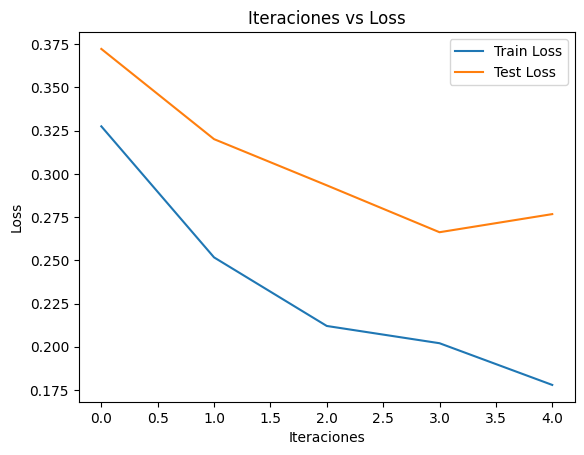

In [ ]:
plt.plot(range(5), loss_train_list, label="Train Loss")
plt.plot(range(5), loss_test_list, label="Test Loss")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.title("Iteraciones vs Loss")
plt.legend()
plt.show()

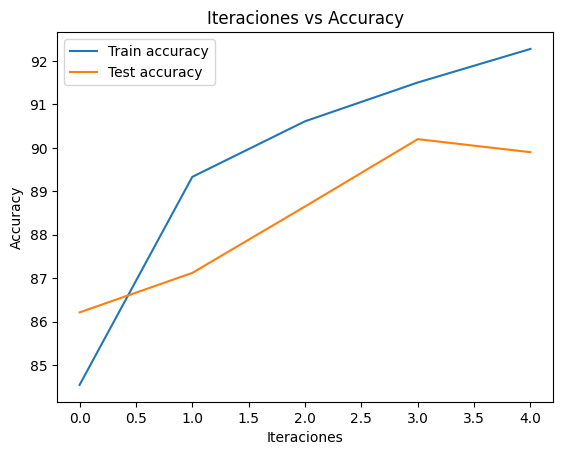

In [ ]:
plt.plot(range(5), accuracy_train_list, label="Train accuracy")
plt.plot(range(5), accuracy_test_list, label="Test accuracy")
plt.xlabel("Iteraciones")
plt.ylabel("Accuracy")
plt.title("Iteraciones vs Accuracy")
plt.legend()
plt.show()

### Accuracy de cada clase

In [25]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():

    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy de {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy de T-shirt/Top: 92.95%
Accuracy de Trouser: 97.13%
Accuracy de Pullover: 85.36%
Accuracy de Dress: 80.36%
Accuracy de Coat: 83.27%
Accuracy de Sandal: 97.54%
Accuracy de Shirt: 49.90%
Accuracy de Sneaker: 95.72%
Accuracy de Bag: 97.97%
Accuracy de Ankle Boot: 96.34%


#### Evaluamos el modelo y generamos el archivo csv para subirlo a la competencia

In [80]:
# Función para evaluar el DataLoader de testeo
def testeo_model(model, test_loader, device):

    model.eval()  # Cambiar a modo evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No calcular gradientes durante la evaluación

        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
            
            # paso Forward
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Obtenemos la clase con mayor probabilidad
            
            # Guardar resultados
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Crear el archivo CSV con IDs y predicciones
def generate__csv(test_loader, predictions, output_file="submission.csv"):

    # Tomamos los ids del dataset de testeo
    ids = pd.read_csv("./fashion-mnist_test.csv")
    ids = [int(x) for x in ids.iloc[:, 0]] 

    submission_df = pd.DataFrame({
        "label": predictions,
        "id": ids
    })
    submission_df.to_csv(output_file, index=False)
    print(f"Archivo '{output_file}' generado correctamente.")

# Evaluamos
predictions, labels = testeo_model(model, test_loader, device)

generate__csv(test_loader, predictions)

c:\Users\franco\OneDrive\Escritorio\BUSCADOR DE OBJETOS\buscaor\lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Archivo 'submission.csv' generado correctamente.
